In [1]:
import copy
import numpy as np
import time
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from transformer_attention import *

Trains a model that uses the Transformer Attention mechanism as described in ["Attention is All You Need" (Vaswani, et al.)](https://arxiv.org/abs/1706.03762)

# Initialization and Setup
The `TransformerAttention` class is defined in the file `transformer_attention.py`.

## Initialize model

In [2]:
def make_model(src_vocab, tgt_vocab, N = 6, d_model = 512, d_ff = 2048, h = 8, dropout = 0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## Training helpers
Classes and functions that handle batching of data and running a single training iteration.

In [3]:
class Batch:
    def __init__(self, src, tgt = None, pad = 0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        )
        return tgt_mask

In [4]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt)+2)
    src_elements = count*max_src_in_batch
    tgt_elements = count*max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [5]:
# Training loop
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss = loss_compute(out, batch.tgt_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch step: %d | Loss: %f | Tokens per sec: %f" %
                 (i, loss/batch.ntokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Optimizer
We use the Adam optimizer with $\beta_1 = 0.9, \beta_2 = 0.98$, and $\epsilon = 10^{-9}$. We vary the learning rate over the course of training according to the formula:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{step_num}^{-0.5}, \text{step_num}\cdot\text{warmup_steps}^{-1.5})}$$

This corresponds to increasing the learning rate lineary for the first $\text{warmup_steps}$ training steps, then decreasing it thereafter proportionally to the inverse square root of the step number.

In [6]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size**(-0.5) * min(step**(-0.5), step*self.warmup**(-1.5)))
    
def get_std_opt(model):
    return NoamOpt(
        model.src_embed[0].d_model, 2, 4000,
        torch.optim.Adam(
            model.parameters(), lr = 0, betas = (0.9, 0.98), eps = 1e-9
        )
    )

Some learning rate curves for various model sizes and warmup steps:

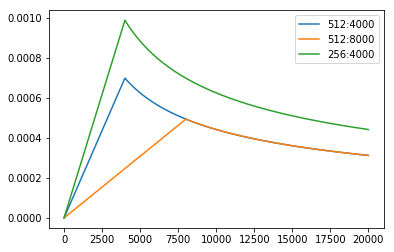

In [7]:
opts = [
    NoamOpt(512, 1, 4000, None),
    NoamOpt(512, 1, 8000, None),
    NoamOpt(256, 1, 4000, None),
]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Regularization
### Label smoothing
During training, we employ label smoothing of value $\epsilon_{\text{lr}} = 0.1$. This hurts perplexity as the model learns to be more unsure, but it improves accuracy and BLEU score.

We implement label smoothing using the KL divergence loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [8]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average = False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False))

Example of how the probability mass is distributed to the words based on confidence:

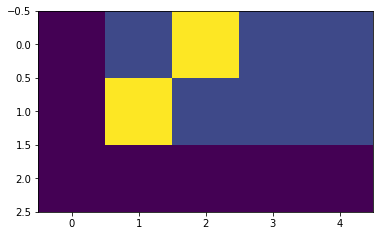

In [9]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice:

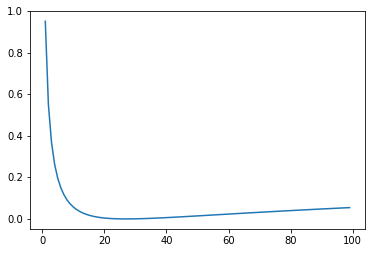

In [10]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[
        0, x/d, 1/d, 1/d, 1/d
    ]])
    return crit(
        Variable(predict.log()),
        Variable(torch.LongTensor([1]))
    ).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

# A First Example
Start by trying out a simple copy task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

### Synthetic data
Function to generate random data for a copy task.

In [11]:
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size = (batch, 10))).type(torch.LongTensor)
        data[:, 0] = 1
        src = Variable(data, requires_grad = False)
        tgt = Variable(data, requires_grad = False)
        yield Batch(src, tgt, 0)

### Loss computation
A simple loss compute and train function.

In [12]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt = None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)),
            y.contiguous().view(-1)
        ) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

### Greedy decoding
Train the simple copy task.

In [13]:
V = 11
criterion = LabelSmoothing(size = V, padding_idx = 0, smoothing = 0.0)
model = make_model(V, V, N = 2)
model_opt = NoamOpt(
    model.src_embed[0].d_model, 1, 400,
    torch.optim.Adam(
        model.parameters(), lr = 0, betas = (0.9, 0.98), eps = 1e-9
    )
)

# Train loop
for epoch in range(10):
    model.train()
    run_epoch(
        data_gen(V, 30, 20), model,
        SimpleLossCompute(model.generator, criterion, model_opt)
    )
    model.eval()
    print(run_epoch(
        data_gen(V, 30, 5), model,
        SimpleLossCompute(model.generator, criterion, None)
    ))

Epoch step: 1 | Loss: 3.107259 | Tokens per sec: 340.850632
Epoch step: 1 | Loss: 1.901908 | Tokens per sec: 510.234121
1.9842022895812987
Epoch step: 1 | Loss: 1.953357 | Tokens per sec: 362.753695
Epoch step: 1 | Loss: 1.723824 | Tokens per sec: 538.547542
1.6954462289810182
Epoch step: 1 | Loss: 1.784584 | Tokens per sec: 361.660841
Epoch step: 1 | Loss: 1.433409 | Tokens per sec: 558.281392
1.4216758012771606
Epoch step: 1 | Loss: 1.481804 | Tokens per sec: 370.095565
Epoch step: 1 | Loss: 1.157793 | Tokens per sec: 559.130226
1.071584939956665
Epoch step: 1 | Loss: 1.209499 | Tokens per sec: 382.262649
Epoch step: 1 | Loss: 0.979096 | Tokens per sec: 562.078684
0.9120646953582764
Epoch step: 1 | Loss: 1.229932 | Tokens per sec: 384.052611
Epoch step: 1 | Loss: 0.552809 | Tokens per sec: 500.794922
0.5966191053390503
Epoch step: 1 | Loss: 1.129921 | Tokens per sec: 329.664041
Epoch step: 1 | Loss: 0.575215 | Tokens per sec: 519.114162
0.6457120180130005
Epoch step: 1 | Loss: 0.5825

In [14]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data))
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([
            ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)
        ], dim = 1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10
]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len = 10, start_symbol = 1))


    1     2     3     4     5     6     7     8     9    10
[torch.LongTensor of size 1x10]

